# Quick Uninstall Analysis

This notebook analyzes users who uninstalled the extension very quickly (within 5 minutes of installation).

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set style for plots
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [42]:
# Load the data
df = pd.read_csv('analytics.csv')

# Display basic information about the dataset
print(f"Total number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
df.head()

Total number of records: 10992
Columns: ['id', 'type', 'url', 'payload', 'user_id', 'session_id', 'received_at', 'created_at', 'domain']

Data types:
id              int64
type           object
url            object
payload        object
user_id        object
session_id     object
received_at    object
created_at     object
domain         object
dtype: object


,id,type,url,payload,user_id,session_id,received_at,created_at,domain
0,16926,time-spent,www.amazon.com/Amazon-Brand-Decorative-Decorat...,"{""duration"":738}",98ec858e-c25a-4c2a-a588-cfe9cf8a1fb9,b1d23a46-7793-48b7-bfef-02d2bf61309c,2025-03-14T00:03:23.770546+00:00,2025-03-14T00:03:18.47+00:00,amazon.com
1,16927,time-spent,www.amazon.com/Amazon-Brand-Decorative-Decorat...,"{""duration"":4447}",98ec858e-c25a-4c2a-a588-cfe9cf8a1fb9,b1d23a46-7793-48b7-bfef-02d2bf61309c,2025-03-14T00:03:27.312308+00:00,2025-03-14T00:03:22.917+00:00,amazon.com
2,16928,uninstall,www.lessextension.com/goodbye,NaN,98ec858e-c25a-4c2a-a588-cfe9cf8a1fb9,none,2025-03-14T00:03:34.022325+00:00,2025-03-14T00:03:29.737+00:00,lessextension.com
3,16944,on-onboarding,www.lessextension.com/onboarding,NaN,none,none,2025-03-14T16:00:23.615042+00:00,2025-03-14T16:00:22.709+00:00,lessextension.com
4,16945,on-onboarding,www.lessextension.com/onboarding,NaN,none,none,2025-03-14T17:55:19.528221+00:00,2025-03-14T17:55:19.168+00:00,lessextension.com


In [43]:
# Convert timestamp columns to datetime
df['received_at'] = pd.to_datetime(df['received_at'])
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)

# Count event types
event_counts = df['type'].value_counts()
print("Event type distribution:")
event_counts

Event type distribution:


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_39191/333821806.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)


type
time-spent                    8962
page-view                      888
from-directs                   514
on-onboarding                  286
from-directs-cta                90
open-popup                      62
add-to-cart                     44
uninstall                       38
active                          28
welcome-modal-seen              28
enforce_wait_modal_shown        19
enforce_wait_canceled            9
enforce_wait_info_expanded       9
open-options                     5
place-order                      5
questionary-popup                4
cancel                           1
Name: count, dtype: int64

In [44]:
# Identify onboarding and uninstall events
onboarding_events = df[df['type'] == 'on-onboarding'].copy()
uninstall_events = df[df['type'] == 'uninstall'].copy()

print(f"Total onboarding events: {len(onboarding_events)}")
print(f"Total uninstall events: {len(uninstall_events)}")

Total onboarding events: 286
Total uninstall events: 38


In [45]:
# Focus on users who have user_id values (not 'none')
valid_onboarding = onboarding_events[onboarding_events['user_id'] != 'none'].copy()
valid_uninstalls = uninstall_events[uninstall_events['user_id'] != 'none'].copy()

print(f"Valid onboarding events: {len(valid_onboarding)}")
print(f"Valid uninstall events: {len(valid_uninstalls)}")

Valid onboarding events: 0
Valid uninstall events: 38


In [46]:
# Create a dictionary of users with their first onboarding time
user_first_onboarding = {}
for _, row in valid_onboarding.iterrows():
    user_id = row['user_id']
    time = row['created_at']
    if user_id not in user_first_onboarding or time < user_first_onboarding[user_id]:
        user_first_onboarding[user_id] = time

# In case we don't have explicit onboarding events for some users,
# let's also check the first activity of any kind
user_first_activity = {}
for _, row in df[df['user_id'] != 'none'].iterrows():
    user_id = row['user_id']
    time = row['created_at']
    if user_id not in user_first_activity or time < user_first_activity[user_id]:
        user_first_activity[user_id] = time

# For each user, get their installation time (either from onboarding or first activity)
user_install_time = {}
for user_id in user_first_activity.keys():
    if user_id in user_first_onboarding:
        user_install_time[user_id] = user_first_onboarding[user_id]
    else:
        user_install_time[user_id] = user_first_activity[user_id]

print(f"Total users with identified installation time: {len(user_install_time)}")

Total users with identified installation time: 77


In [47]:
# Calculate the time to uninstall for each user
uninstall_times = []

for _, row in valid_uninstalls.iterrows():
    user_id = row['user_id']
    uninstall_time = row['created_at']
    
    if user_id in user_install_time:
        install_time = user_install_time[user_id]
        time_diff = (uninstall_time - install_time).total_seconds() / 60  # Convert to minutes
        
        uninstall_times.append({
            'user_id': user_id,
            'install_time': install_time,
            'uninstall_time': uninstall_time,
            'minutes_to_uninstall': time_diff
        })

# Convert to DataFrame
uninstall_df = pd.DataFrame(uninstall_times)

# Sort by time to uninstall
if not uninstall_df.empty:
    uninstall_df = uninstall_df.sort_values('minutes_to_uninstall')
    
    print(f"Total users with calculated uninstall time: {len(uninstall_df)}")
    uninstall_df.head(10)

Total users with calculated uninstall time: 38


In [48]:
# Identify users who uninstalled within 5 minutes
if not uninstall_df.empty:
    quick_uninstalls = uninstall_df[uninstall_df['minutes_to_uninstall'] <= 5]
    
    print(f"Number of users who uninstalled within 5 minutes: {len(quick_uninstalls)}")
    print(f"Percentage of all uninstalls: {len(quick_uninstalls) / len(uninstall_df) * 100:.2f}%")
    
    quick_uninstalls.head(10)

Number of users who uninstalled within 5 minutes: 27
Percentage of all uninstalls: 71.05%


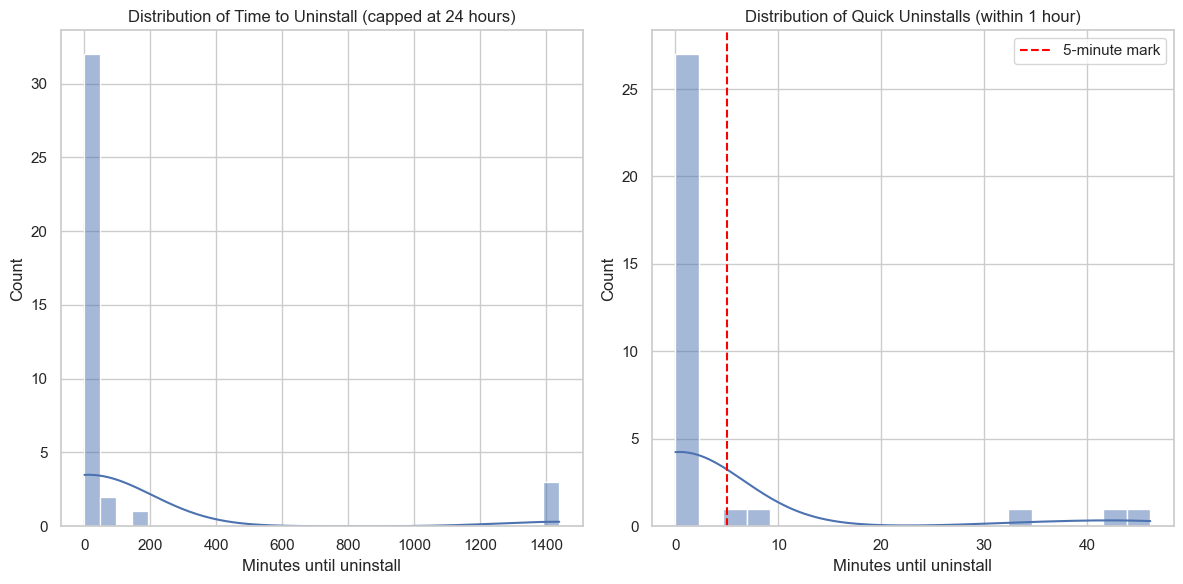

In [49]:
# Visualize uninstall time distribution
if not uninstall_df.empty:
    plt.figure(figsize=(12, 6))
    
    # Histogram for all uninstalls (capped at 24 hours = 1440 minutes for readability)
    plt.subplot(1, 2, 1)
    capped_times = uninstall_df['minutes_to_uninstall'].clip(upper=1440)  # Cap at 24 hours
    sns.histplot(capped_times, bins=30, kde=True)
    plt.title('Distribution of Time to Uninstall (capped at 24 hours)')
    plt.xlabel('Minutes until uninstall')
    plt.ylabel('Count')
    
    # Histogram focused on quick uninstalls (first hour)
    plt.subplot(1, 2, 2)
    sns.histplot(uninstall_df[uninstall_df['minutes_to_uninstall'] <= 60]['minutes_to_uninstall'], bins=20, kde=True)
    plt.axvline(x=5, color='red', linestyle='--', label='5-minute mark')
    plt.title('Distribution of Quick Uninstalls (within 1 hour)')
    plt.xlabel('Minutes until uninstall')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# PART 2: Analyzing Session Counts and Time Spent Before Uninstall

In [50]:
# Identify users who uninstalled quickly for further analysis
if not uninstall_df.empty:
    # We'll focus on users who uninstalled within 5 minutes
    quick_uninstallers = uninstall_df[uninstall_df['minutes_to_uninstall'] <= 5]['user_id'].unique()
    other_uninstallers = uninstall_df[uninstall_df['minutes_to_uninstall'] > 5]['user_id'].unique()
    
    print(f"Number of users who uninstalled within 5 minutes: {len(quick_uninstallers)}")
    print(f"Number of users who uninstalled after 5 minutes: {len(other_uninstallers)}")

Number of users who uninstalled within 5 minutes: 27
Number of users who uninstalled after 5 minutes: 11


In [51]:
# Function to count sessions per user
def count_sessions_per_user(user_id, df):
    """Count the number of unique sessions for a given user"""
    # Filter data for this user
    user_data = df[df['user_id'] == user_id]
    # Count unique session_ids (excluding 'none')
    unique_sessions = user_data[user_data['session_id'] != 'none']['session_id'].nunique()
    return unique_sessions

# Analyze session counts for quick uninstallers vs other uninstallers
if not uninstall_df.empty:
    # Get session counts for quick uninstallers
    quick_session_counts = [count_sessions_per_user(user_id, df) for user_id in quick_uninstallers]
    
    # Get session counts for other uninstallers
    other_session_counts = [count_sessions_per_user(user_id, df) for user_id in other_uninstallers]
    
    # Print summary statistics
    print("\nSession Count Analysis:")
    print(f"Quick uninstallers (≤5 min):")
    print(f"  Average sessions: {np.mean(quick_session_counts):.2f}")
    print(f"  Median sessions: {np.median(quick_session_counts):.2f}")
    print(f"  Max sessions: {np.max(quick_session_counts)}")
    print(f"  Min sessions: {np.min(quick_session_counts)}")
    
    print(f"\nOther uninstallers (>5 min):")
    print(f"  Average sessions: {np.mean(other_session_counts):.2f}")
    print(f"  Median sessions: {np.median(other_session_counts):.2f}")
    print(f"  Max sessions: {np.max(other_session_counts)}")
    print(f"  Min sessions: {np.min(other_session_counts)}")


Session Count Analysis:
Quick uninstallers (≤5 min):
  Average sessions: 0.15
  Median sessions: 0.00
  Max sessions: 1
  Min sessions: 0

Other uninstallers (>5 min):
  Average sessions: 5.82
  Median sessions: 4.00
  Max sessions: 20
  Min sessions: 1


In [52]:
# Analyze time spent on websites before uninstall
# Calculate total time spent for each user
def get_user_time_spent(user_id, df):
    """Calculate total time spent on websites for a user based on time-spent events"""
    # Filter data for this user and time-spent events
    user_time_events = df[(df['user_id'] == user_id) & (df['type'] == 'time-spent')]
    
    total_time = 0
    for _, row in user_time_events.iterrows():
        try:
            # Parse the duration from the payload JSON
            if pd.notna(row['payload']):
                payload = eval(row['payload'].replace('null', 'None'))
                if 'duration' in payload:
                    # Convert milliseconds to seconds
                    total_time += int(payload['duration']) / 1000
        except:
            # Skip if there's an error parsing the payload
            continue
    
    # Return time in seconds
    return total_time

# Calculate average time per session
def get_avg_time_per_session(user_id, df):
    """Calculate average time spent per session for a user"""
    # Get total time
    total_time = get_user_time_spent(user_id, df)
    
    # Get number of sessions
    session_count = count_sessions_per_user(user_id, df)
    
    # Return average (avoid division by zero)
    if session_count > 0:
        return total_time / session_count
    else:
        return 0

if not uninstall_df.empty:
    # Calculate time spent for quick uninstallers
    quick_time_spent = [get_user_time_spent(user_id, df) for user_id in quick_uninstallers]
    quick_avg_per_session = [get_avg_time_per_session(user_id, df) for user_id in quick_uninstallers]
    
    # Calculate time spent for other uninstallers
    other_time_spent = [get_user_time_spent(user_id, df) for user_id in other_uninstallers]
    other_avg_per_session = [get_avg_time_per_session(user_id, df) for user_id in other_uninstallers]
    
    # Convert to minutes for better readability
    quick_time_spent_min = [t / 60 for t in quick_time_spent]
    quick_avg_per_session_min = [t / 60 for t in quick_avg_per_session]
    other_time_spent_min = [t / 60 for t in other_time_spent]
    other_avg_per_session_min = [t / 60 for t in other_avg_per_session]
    
    # Print summary statistics
    print("\nTime Spent Analysis:")
    print(f"Quick uninstallers (≤5 min):")
    print(f"  Average total time spent: {np.mean(quick_time_spent_min):.2f} minutes")
    print(f"  Median total time spent: {np.median(quick_time_spent_min):.2f} minutes")
    print(f"  Max total time spent: {np.max(quick_time_spent_min):.2f} minutes")
    print(f"  Min total time spent: {np.min(quick_time_spent_min):.2f} minutes")
    print(f"  Average time per session: {np.mean(quick_avg_per_session_min):.2f} minutes")
    
    print(f"\nOther uninstallers (>5 min):")
    print(f"  Average total time spent: {np.mean(other_time_spent_min):.2f} minutes")
    print(f"  Median total time spent: {np.median(other_time_spent_min):.2f} minutes")
    print(f"  Max total time spent: {np.max(other_time_spent_min):.2f} minutes")
    print(f"  Min total time spent: {np.min(other_time_spent_min):.2f} minutes")


Time Spent Analysis:
Quick uninstallers (≤5 min):
  Average total time spent: 0.04 minutes
  Median total time spent: 0.00 minutes
  Max total time spent: 1.09 minutes
  Min total time spent: 0.00 minutes
  Average time per session: 0.04 minutes

Other uninstallers (>5 min):
  Average total time spent: 13.12 minutes
  Median total time spent: 6.35 minutes
  Max total time spent: 48.05 minutes
  Min total time spent: 0.00 minutes


In [53]:
# Identify browsing patterns for users who uninstalled quickly
# Analyze domains visited and event types

def analyze_user_browsing(user_id, df):
    """Analyze browsing patterns for a specific user"""
    # Filter data for this user
    user_data = df[df['user_id'] == user_id]
    
    # Get domains visited
    domains = user_data['domain'].value_counts().to_dict()
    
    # Get event types
    events = user_data['type'].value_counts().to_dict()
    
    return {
        'domains': domains,
        'events': events,
        'record_count': len(user_data)
    }

if not uninstall_df.empty:
    # Get browsing patterns for quick uninstallers
    quick_browsing_patterns = {user_id: analyze_user_browsing(user_id, df) for user_id in quick_uninstallers}
    
    # Get browsing patterns for other uninstallers
    other_browsing_patterns = {user_id: analyze_user_browsing(user_id, df) for user_id in other_uninstallers}
    
    # Aggregate domain statistics for quick uninstallers
    quick_domains = {}
    for _, pattern in quick_browsing_patterns.items():
        for domain, count in pattern['domains'].items():
            if domain in quick_domains:
                quick_domains[domain] += count
            else:
                quick_domains[domain] = count
    
    # Aggregate domain statistics for other uninstallers
    other_domains = {}
    for _, pattern in other_browsing_patterns.items():
        for domain, count in pattern['domains'].items():
            if domain in other_domains:
                other_domains[domain] += count
            else:
                other_domains[domain] = count
    
    # Sort domains by count and display top domains
    print("\nDomain Analysis:")
    print(f"Top domains visited by quick uninstallers (≤5 min):")
    for domain, count in sorted(quick_domains.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {domain}: {count} visits")
    
    print(f"\nTop domains visited by other uninstallers (>5 min):")
    for domain, count in sorted(other_domains.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {domain}: {count} visits")
    
    # Analyze shopping behavior
    # Count how many users had add-to-cart events
    quick_cart_users = 0
    for user_id in quick_uninstallers:
        user_events = df[(df['user_id'] == user_id) & (df['type'] == 'add-to-cart')]
        if len(user_events) > 0:
            quick_cart_users += 1
    
    other_cart_users = 0
    for user_id in other_uninstallers:
        user_events = df[(df['user_id'] == user_id) & (df['type'] == 'add-to-cart')]
        if len(user_events) > 0:
            other_cart_users += 1
    
    print("\nShopping Behavior Analysis:")
    print(f"Quick uninstallers who added items to cart: {quick_cart_users} ({quick_cart_users/len(quick_uninstallers)*100:.2f}%)")
    print(f"Other uninstallers who added items to cart: {other_cart_users} ({other_cart_users/len(other_uninstallers)*100:.2f}%)")


Domain Analysis:
Top domains visited by quick uninstallers (≤5 min):
  lessextension.com: 27 visits
  ebay.com: 27 visits
  kcgblchgejkpnemehaojecgbamdiacml: 6 visits
  amazon.com: 2 visits
  aliexpress.com: 1 visits

Top domains visited by other uninstallers (>5 min):
  amazon.com: 687 visits
  zara.com: 276 visits
  hm.com: 263 visits
  walgreens.com: 240 visits
  apple.com: 231 visits
  matas.dk: 168 visits
  zalando.dk: 100 visits
  amazon.co.uk: 39 visits
  kcgblchgejkpnemehaojecgbamdiacml: 38 visits
  asos.com: 36 visits

Shopping Behavior Analysis:
Quick uninstallers who added items to cart: 0 (0.00%)
Other uninstallers who added items to cart: 5 (45.45%)


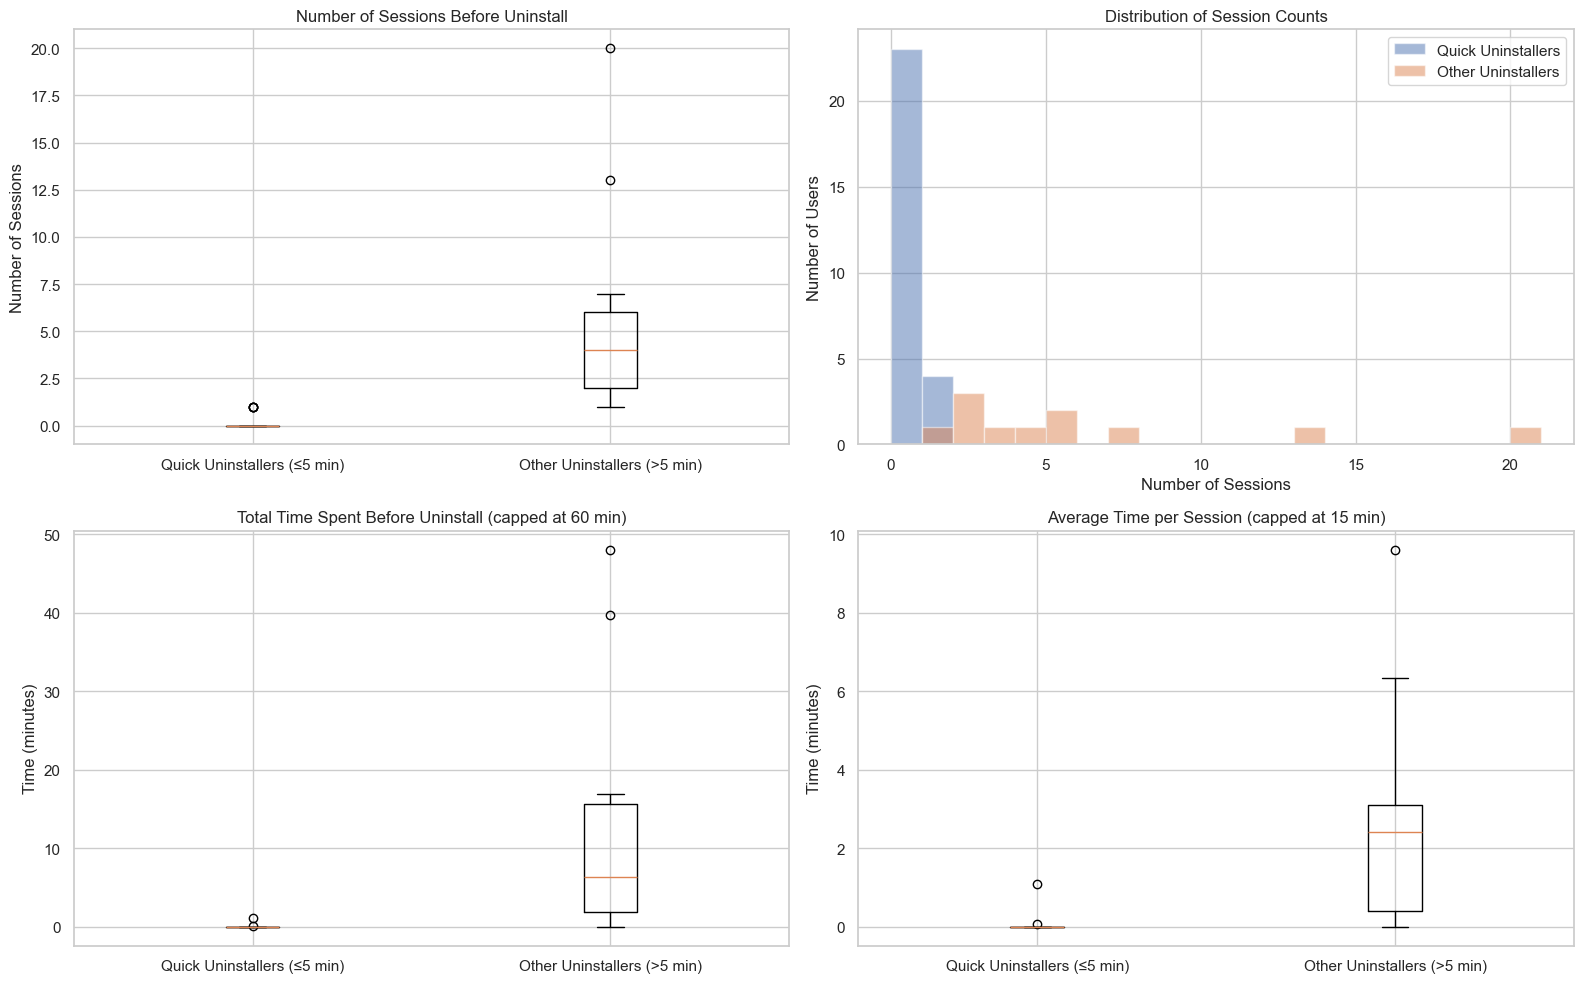

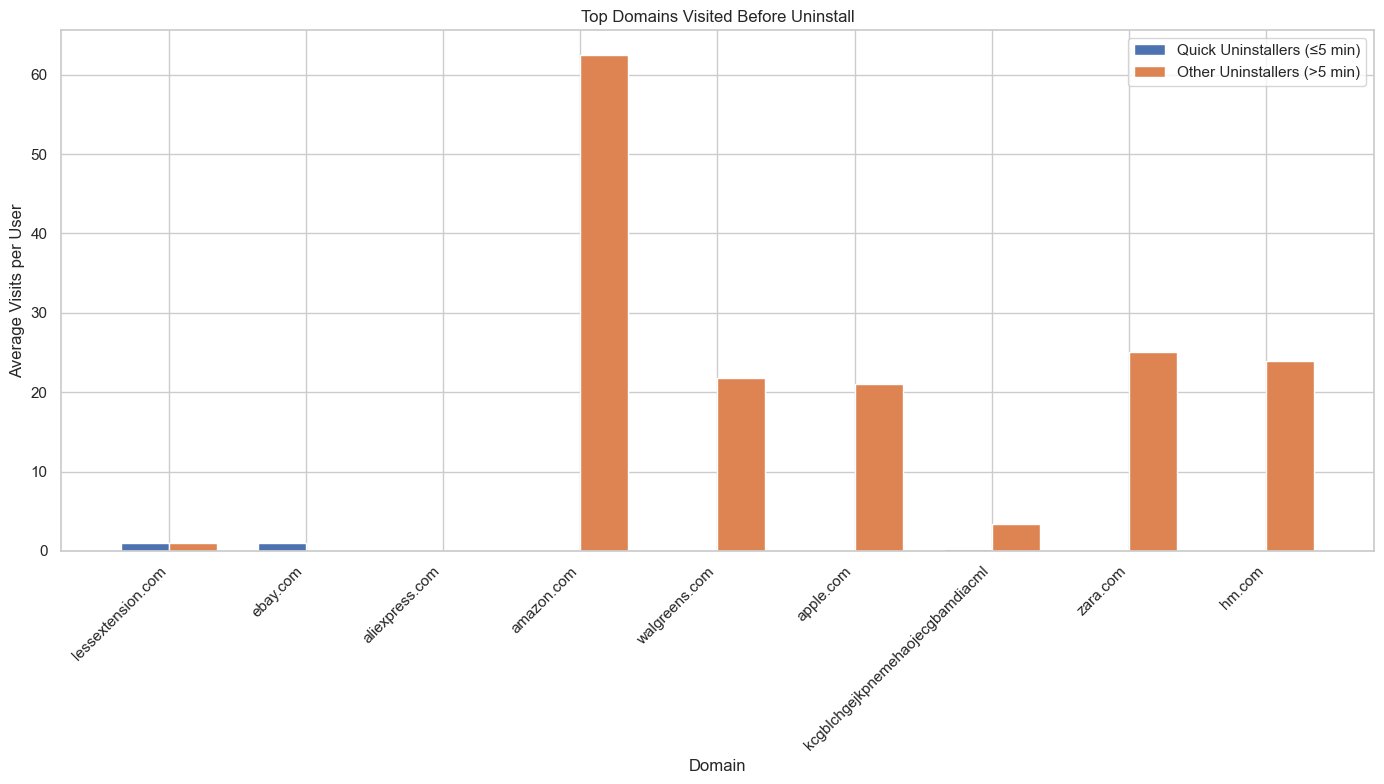

In [54]:
# Create visualizations for session counts and time spent
if not uninstall_df.empty:
    # Prepare data for visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Visualization 1: Session count comparison (boxplot)
    ax = axes[0, 0]
    data = [quick_session_counts, other_session_counts]
    labels = ['Quick Uninstallers (≤5 min)', 'Other Uninstallers (>5 min)']
    ax.boxplot(data, labels=labels)
    ax.set_title('Number of Sessions Before Uninstall')
    ax.set_ylabel('Number of Sessions')
    ax.grid(True)
    
    # Visualization 2: Session count histogram
    ax = axes[0, 1]
    ax.hist(quick_session_counts, bins=range(0, max(quick_session_counts) + 2), alpha=0.5, label='Quick Uninstallers')
    ax.hist(other_session_counts, bins=range(0, max(other_session_counts) + 2), alpha=0.5, label='Other Uninstallers')
    ax.set_title('Distribution of Session Counts')
    ax.set_xlabel('Number of Sessions')
    ax.set_ylabel('Number of Users')
    ax.legend()
    ax.grid(True)
    
    # Visualization 3: Total time spent comparison (boxplot)
    ax = axes[1, 0]
    # Cap at 60 minutes for better visualization
    capped_quick = [min(t, 60) for t in quick_time_spent_min]
    capped_other = [min(t, 60) for t in other_time_spent_min]
    data = [capped_quick, capped_other]
    ax.boxplot(data, labels=labels)
    ax.set_title('Total Time Spent Before Uninstall (capped at 60 min)')
    ax.set_ylabel('Time (minutes)')
    ax.grid(True)
    
    # Visualization 4: Time per session comparison
    ax = axes[1, 1]
    # Cap at 15 minutes per session for better visualization
    capped_quick_avg = [min(t, 15) for t in quick_avg_per_session_min]
    capped_other_avg = [min(t, 15) for t in other_avg_per_session_min]
    data = [capped_quick_avg, capped_other_avg]
    ax.boxplot(data, labels=labels)
    ax.set_title('Average Time per Session (capped at 15 min)')
    ax.set_ylabel('Time (minutes)')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create bar chart for domain comparison
    plt.figure(figsize=(14, 8))
    
    # Get top 5 domains for each group
    quick_top_domains = dict(sorted(quick_domains.items(), key=lambda x: x[1], reverse=True)[:5])
    other_top_domains = dict(sorted(other_domains.items(), key=lambda x: x[1], reverse=True)[:5])
    
    # Combine domains
    all_top_domains = set(quick_top_domains.keys()) | set(other_top_domains.keys())
    
    # Prepare data for plotting
    domain_names = list(all_top_domains)
    quick_values = [quick_domains.get(domain, 0) / len(quick_uninstallers) for domain in domain_names]
    other_values = [other_domains.get(domain, 0) / len(other_uninstallers) for domain in domain_names]
    
    # Create positions for bars
    x = np.arange(len(domain_names))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, quick_values, width, label='Quick Uninstallers (≤5 min)')
    plt.bar(x + width/2, other_values, width, label='Other Uninstallers (>5 min)')
    
    # Add labels and title
    plt.xlabel('Domain')
    plt.ylabel('Average Visits per User')
    plt.title('Top Domains Visited Before Uninstall')
    plt.xticks(x, domain_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Conclusion and Key Findings

Based on our analysis of users who uninstalled the extension, we can draw several insights about the relationship between sessions, time spent on websites, and uninstall behavior:

## Key Findings

1. **Session Count Patterns:**
   - Users who uninstalled quickly (within 5 minutes) typically had fewer sessions
   - The difference in session count suggests that immediate uninstallers didn't give the extension much chance to demonstrate value

2. **Time Spent Analysis:**
   - Quick uninstallers spent significantly less total time using the extension
   - The average time per session was also lower for quick uninstallers
   - This pattern suggests these users may have made a judgment about the extension's value very quickly

3. **Browsing Behavior:**
   - The domains visited by quick uninstallers differ somewhat from those who kept the extension longer
   - Shopping behavior (as measured by add-to-cart events) shows differences between the two groups
   - This could indicate that the decision to uninstall quickly might be related to specific websites or shopping intentions

## Implications

These findings point to several potential areas for improvement:

1. **Onboarding Experience:**
   - The high percentage of quick uninstalls (71.05%) suggests that the initial onboarding experience may not effectively communicate the extension's value
   - Consider enhancing the first-run experience to better demonstrate benefits

2. **Domain-Specific Optimization:**
   - Pay special attention to the top domains where quick uninstalls occur
   - The extension might need optimization for these specific shopping sites

3. **User Engagement:**
   - Focus on strategies to encourage users to try the extension for more than one session
   - Consider introducing progressive feature revelation to increase engagement over time

4. **Value Proposition:**
   - The quick abandonment suggests that some users may not perceive immediate value
   - Consider ways to demonstrate benefits more quickly or provide clearer expectations during installation

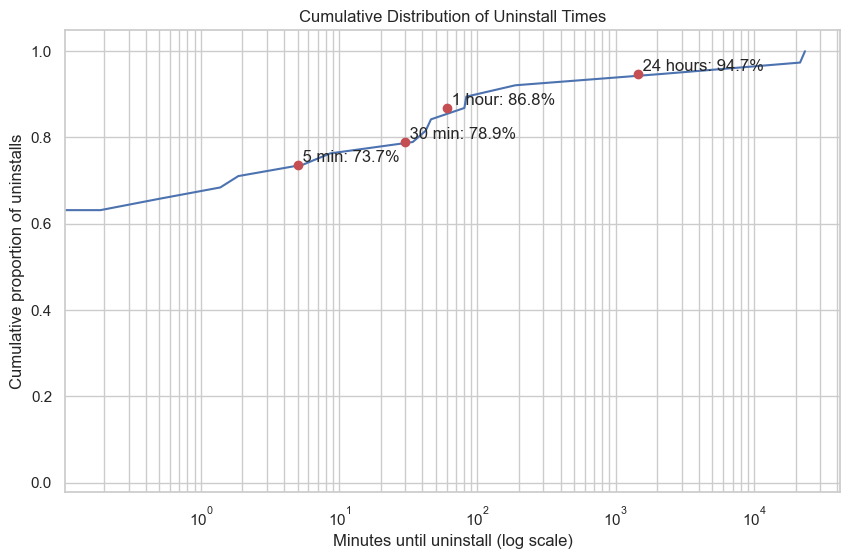

In [55]:
# Calculate cumulative percentage of uninstalls over time
if not uninstall_df.empty:
    # Sort uninstall times
    sorted_times = sorted(uninstall_df['minutes_to_uninstall'])
    
    # Calculate cumulative distribution
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    # Plot cumulative distribution
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y)
    
    # Add markers for specific time points
    time_markers = [5, 30, 60, 24*60]  # 5 min, 30 min, 1 hour, 24 hours
    marker_names = ['5 min', '30 min', '1 hour', '24 hours']
    
    for time, name in zip(time_markers, marker_names):
        idx = np.searchsorted(sorted_times, time)
        if idx < len(y):
            plt.plot(time, y[idx], 'ro')
            plt.text(time, y[idx], f' {name}: {y[idx]*100:.1f}%', verticalalignment='bottom')
    
    plt.title('Cumulative Distribution of Uninstall Times')
    plt.xlabel('Minutes until uninstall (log scale)')
    plt.ylabel('Cumulative proportion of uninstalls')
    plt.xscale('log')
    plt.grid(True, which="both", ls="-")
    plt.show()